### DFTSNN - DFT Encoded with updated weights - parellel processing

In [1]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

In [2]:
%reset -f  # clears all variables, history, and caches
import gc
gc.collect()

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  variables,, please run `%reset?` for details
Don't know how to reset  history,, please run `%reset?` for details
Don't know how to reset  and, please run `%reset?` for details
Don't know how to reset  caches, please run `%reset?` for details


0

In [3]:
import numpy as np

np.random.seed(42)

n = 16
q = 5
num_samples = 1000

def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

n = n_padded

Original n: 16
Padded n: 16
Generated dataset shape: (1000, 16)


In [4]:
print(dataset)
print(dataset.shape)
print(dataset[0].shape)

[[3 4 2 ... 1 3 1]
 [3 4 0 ... 3 2 3]
 [3 0 2 ... 0 1 4]
 ...
 [4 4 4 ... 0 2 2]
 [4 2 4 ... 4 0 0]
 [2 2 2 ... 0 4 2]]
(1000, 16)
(16,)


In [5]:
def dft(u, n):
    n1 = n // 2
    if n == 2:  
        return np.array([u[0] + u[1], u[0] - u[1]])
    
    zeta = np.exp(-2j * np.pi / n)
    Dn = np.diag([zeta**k for k in range(n1)])
    Hn = np.block([[np.eye(n1), np.eye(n1)],
                   [Dn, -Dn]])
    
    p = np.dot(Hn, u)
    
    s1 = dft(p[:n1], n1)
    s2 = dft(p[n1:], n1)
    
    interleaved = np.empty((len(s1) + len(s2)), dtype=complex)
    interleaved[0::2] = s1
    interleaved[1::2] = s2
    
    y = interleaved
    return y

In [6]:
encoded_dataset = np.array([dft(message, n) for message in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)
print(encoded_dataset)

[[42.         +0.j          0.84148733 -0.81622894j
  -0.87867966 -6.36396103j ... -1.2304425  -1.25570089j
  -0.87867966 +6.36396103j  0.84148733 +0.81622894j]
 [34.         +0.j          5.88076075 +0.31815162j
  -2.41421356 +3.j         ...  6.11085797 -0.77903661j
  -2.41421356 -3.j          5.88076075 -0.31815162j]
 [29.         +0.j          2.38895517 -4.90489287j
   0.17157288 -1.17157288j ...  2.07192983 -7.86463619j
   0.17157288 +1.17157288j  2.38895517 +4.90489287j]
 ...
 [37.         +0.j          6.60006572-11.28512148j
   2.70710678 -0.70710678j ... -0.68037683 +4.15172419j
   2.70710678 +0.70710678j  6.60006572+11.28512148j]
 [40.         +0.j         -4.28191411 +3.31849689j
   0.70710678 -3.70710678j ...  1.90134022+10.29671013j
   0.70710678 +3.70710678j -4.28191411 -3.31849689j]
 [35.         +0.j         -2.11652017 +0.96427923j
   2.41421356 +0.34314575j ...  0.28130457 -2.5159377j
   2.41421356 -0.34314575j -2.11652017 -0.96427923j]]


In [7]:
print(encoded_dataset.shape)

(1000, 16)


In [8]:
print(dataset[0])
print(encoded_dataset[0])

[3 4 2 4 4 1 2 2 2 4 3 2 4 1 3 1]
[42.        +0.j          0.84148733-0.81622894j -0.87867966-6.36396103j
 -1.2304425 +1.25570089j  3.        -1.j          3.2304425 -1.57272623j
 -5.12132034-6.36396103j  1.15851267-3.64465606j  4.        +0.j
  1.15851267+3.64465606j -5.12132034+6.36396103j  3.2304425 +1.57272623j
  3.        +1.j         -1.2304425 -1.25570089j -0.87867966+6.36396103j
  0.84148733+0.81622894j]


In [ ]:
# Normalize to zero mean and unit variance - output results of normalizing made unseen data converge to q-1
# encoded_dataset = (encoded_dataset - np.mean(encoded_dataset, axis=0)) / np.std(encoded_dataset, axis=0)
# print(encoded_dataset[0])

In [10]:
X_real = np.real(encoded_dataset).astype(np.float32)
X_imag = np.imag(encoded_dataset).astype(np.float32)

print("\nX_train_real :", X_real.shape)
print(X_real[0])
print("\nX_train_imag :", X_imag.shape)
print(X_imag[0])


X_train_real : (1000, 16)
[42.          0.84148735 -0.87867963 -1.2304425   3.          3.2304425
 -5.1213202   1.1585127   4.          1.1585127  -5.1213202   3.2304425
  3.         -1.2304425  -0.87867963  0.84148735]

X_train_imag : (1000, 16)
[ 0.        -0.8162289 -6.363961   1.255701  -1.        -1.5727262
 -6.363961  -3.644656   0.         3.644656   6.363961   1.5727262
  1.        -1.255701   6.363961   0.8162289]


In [11]:
# normalize target data (integers 0-q to [0, 1])
y_normalized = dataset.astype(np.float32) / (q - 1)  # Scale to [0, 1]
print("y: ")
print(dataset.astype(np.float32)[0])
print("\ny_normalized: ")
print(y_normalized[0])

labels = y_normalized

y: 
[3. 4. 2. 4. 4. 1. 2. 2. 2. 4. 3. 2. 4. 1. 3. 1.]

y_normalized: 
[0.75 1.   0.5  1.   1.   0.25 0.5  0.5  0.5  1.   0.75 0.5  1.   0.25
 0.75 0.25]


In [12]:
from sklearn.model_selection import train_test_split

X_real_train, X_real_test, y_train, y_test = train_test_split(
    X_real, labels, test_size=0.2, random_state=42
)

X_imag_train, X_imag_test, _, _ = train_test_split(
    X_imag, labels, test_size=0.2, random_state=42
)

print("Training data shapes: X_real:", X_real_train.shape, "X_imag:", X_imag_train.shape, "y:", y_train.shape)
print("Testing data shapes: X_real:", X_real_test.shape, "X_imag:", X_imag_test.shape, "y:", y_test.shape)

Training data shapes: X_real: (800, 16) X_imag: (800, 16) y: (800, 16)
Testing data shapes: X_real: (200, 16) X_imag: (200, 16) y: (200, 16)


In [13]:
print(X_real_train.shape[1])
print(X_real_test.shape[1])
print(X_imag_train.shape[1])
print(X_imag_test.shape[1])
print(y_train.shape[1])
print(y_test.shape[1])

16
16
16
16
16
16


In [14]:
input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
print(input_dim)
print(output_dim)

16
16


IDFT - Structure Imposed Neural Network

In [15]:
import tensorflow as tf

In [16]:
class FirstLayer(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, **kwargs):
        super(FirstLayer, self).__init__(**kwargs)
        self.units = units  # Features/neurons (16)
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units # --> 32
        n1 = n // 2 # --> 16
        num_blocks = n1 // 2 # --> 8
        
        self.b_1 = self.add_weight(name="kernel_b1",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.HeNormal(), #GlorotNormal
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.b_2 = self.add_weight(name="kernel_b2",
                                   shape=(num_blocks, 2, 2),
                                   initializer=tf.keras.initializers.HeNormal(),
                                #    regularizer=tf.keras.regularizers.l2(1e-5),
                                   trainable=True)
        self.d_1 = self.add_weight(name="kernel_d1", 
                                  shape=(n1-2,), 
                                  initializer=tf.keras.initializers.HeNormal(),
                                #   regularizer=tf.keras.regularizers.l2(1e-5),
                                  trainable=True)
        self.d_2 = self.add_weight(name="kernel_d2", 
                                  shape=(n1-2,), 
                                  initializer=tf.keras.initializers.HeNormal(),
                                #   regularizer=tf.keras.regularizers.l2(1e-5),
                                  trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias", 
                                        shape=(self.units,), 
                                        initializer=tf.keras.initializers.Zeros(),
                                        trainable=True)

    def call(self, inputs):
        # print("Enters first layer")

        def recursiveIDFT(inputVector, B, d, level):
            n = inputVector.shape[1]
            n1 = n // 2

            if n == 2:
                out = tf.matmul(inputVector, B[level])
                return out

            else:
                q = tf.concat([inputVector[:, ::2], inputVector[:, 1::2]], axis=1)

                B1 = recursiveIDFT(q[:, :n1], B, d[n1:], level + 1)
                B2 = recursiveIDFT(q[:, n1:], B, d[n1:], level + 1)

                d_n = tf.reshape(d[:n1], (1, -1))
                z1 = tf.concat([(B1 + tf.multiply(B2, d_n)), (B1 - tf.multiply(B2, d_n))], axis=1)
                
                return z1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))


        n = self.units 
        n1 = n // 2

        q = tf.concat([inputs[:, ::2], inputs[:, 1::2]], axis=1)

        B1 = recursiveIDFT(q[:, :n1], self.b_1, self.d_1, level=0)
        B2 = recursiveIDFT(q[:, n1:], self.b_2, self.d_2, level=0)

        out = tf.concat([B1, B2], axis=1)

        if self.use_bias:
            out += self.bias

        return out

In [17]:
class SecondLayer(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, **kwargs):
        super(SecondLayer, self).__init__(**kwargs)
        self.units = units # features/neurons (16)
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        n1 = n//2
        
        self.d_1 = self.add_weight(name ="kernel_d1",
                                      shape=(n1,),
                                      initializer=tf.keras.initializers.HeNormal(),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(n,),
                                       initializer=tf.keras.initializers.Zeros(),
                                       trainable=True)

    def call(self, inputs):
        
        out1 = inputs[:, :int(inputs.shape[1] / 2)]
        out2 = inputs[:, int(inputs.shape[1] / 2):]
        
        z1 = tf.concat([(out1 + tf.multiply(out2, self.d_1)), (out1 - tf.multiply(out2, self.d_1))], axis=1)
        
        out = z1 / tf.sqrt(tf.constant(2.0, dtype=tf.float32))
        
        if self.use_bias:
            out += self.bias

        return out

In [18]:
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        
        self.m = self.add_weight(name ="kernel_m",
                                      shape=(n,),
                                      initializer=tf.keras.initializers.HeNormal(),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.Zeros(),
                                       trainable=True)

    def call(self, inputs):
        # print("Enters custom layer")
        out = tf.multiply(inputs, self.m)
        
        if self.use_bias:
            out += self.bias

        return out

In [ ]:
class LinearLayer(tf.keras.layers.Layer):
    def __init__(self, units, use_bias=True, **kwargs):
        super(LinearLayer, self).__init__(**kwargs)
        self.units = units # features/neurons
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units
        
        self.m = self.add_weight(name ="kernel_m_1",
                                      shape=(n,),
                                      initializer=tf.keras.initializers.Ones(),
                                      trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name ="bias",
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.Zeros(),
                                       trainable=True)

    def call(self, inputs):
        print("linear layer input:", inputs.shape)
        
        inputs1 = inputs[:, :int(inputs.shape[1] / 2)]
        inputs2 = inputs[:, int(inputs.shape[1] / 2):]
        
        out = tf.math.sqrt(inputs1**2 + inputs2**2)
        
        out = tf.multiply(out, self.m)
        
        if self.use_bias:
            out += self.bias
            
        print("linear layer output:", out.shape)
            
        return out

Build Model

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, Activation, BatchNormalization
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

def cosine_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=-1)

    return 1 - tf.reduce_mean(tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1))  # 1 - Cosine similarity


def hybrid_loss(y_true, y_pred):
    mse_part = tf.reduce_mean(tf.square(y_true - y_pred))  # Regular MSE
    cos_part = cosine_loss(y_true, y_pred)  # Vector-based comparison
    return mse_part + cos_part


def structured_NN(input_dim, output_dim):
    real_input = Input(shape=(input_dim,), name="real_input")
    imag_input = Input(shape=(input_dim,), name="imag_input")

    # real part
    real_x = FirstLayer(units=input_dim, name="real_layer1")(real_input)
    real_x = LeakyReLU(alpha=0.1)(real_x)
    real_x = CustomLayer(units=input_dim, name="real_support_layer_1")(real_x)
    real_x = LeakyReLU(alpha=0.1)(real_x)
    real_x = SecondLayer(units=input_dim, name="real_layer2")(real_x)
    real_x = LeakyReLU(alpha=0.1)(real_x)

    # imaginary part
    imag_x = FirstLayer(units=input_dim, name="imag_layer1")(imag_input)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    imag_x = CustomLayer(units=input_dim, name="imag_support_layer_1")(imag_x)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    imag_x = SecondLayer(units=input_dim, name="imag_layer2")(imag_x)
    imag_x = LeakyReLU(alpha=0.1)(imag_x)
    

    merged = Concatenate(name="merge_real_imag")([real_x, imag_x])

    output = LinearLayer(units=output_dim, name="output_layer")(merged)
    output = Activation('sigmoid')(output)  # linear - Keep outputs unrestricted

    model = Model(inputs=[real_input, imag_input], outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=hybrid_loss, #'mean_squared_error',
        metrics=['mse', 'mae']
    )

    return model


input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
model = structured_NN(input_dim, output_dim)
model.summary()


linear layer input: (None, 32)
linear layer output: (None, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 real_input (InputLayer)     [(None, 16)]                 0         []                            
                                                                                                  
 imag_input (InputLayer)     [(None, 16)]                 0         []                            
                                                                                                  
 real_layer1 (FirstLayer)    (None, 16)                   60        ['real_input[0][0]']          
                                                                                                  
 imag_layer1 (FirstLayer)    (None, 16)                   60        ['imag_input[0][0]']          
                              

In [21]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

real_input [(None, 16)]
imag_input [(None, 16)]
real_layer1 (None, 16)
imag_layer1 (None, 16)
leaky_re_lu (None, 16)
leaky_re_lu_3 (None, 16)
real_support_layer_1 (None, 16)
imag_support_layer_1 (None, 16)
leaky_re_lu_1 (None, 16)
leaky_re_lu_4 (None, 16)
real_layer2 (None, 16)
imag_layer2 (None, 16)
leaky_re_lu_2 (None, 16)
leaky_re_lu_5 (None, 16)
merge_real_imag (None, 32)
output_layer (None, 16)
activation (None, 16)


Train Model

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [23]:
history = model.fit(
    [X_real_train, X_imag_train],
    y_train,
    epochs=500,
    batch_size=16,
    validation_data=([X_real_test, X_imag_test], y_test),
    callbacks=[adjust_lr, early_stopping]
)

Epoch 1/500
linear layer input: (16, 32)
linear layer output: (16, 16)


linear layer input: (16, 32)
linear layer output: (16, 16)
45/50 [==========================>...] - ETA: 0s - loss: 0.3999 - mse: 0.1855 - mae: 0.3543linear layer input: (None, 32)
linear layer output: (None, 16)
50/50 [==============================] - 6s 26ms/step - loss: 0.3981 - mse: 0.1845 - mae: 0.3539 - val_loss: 0.3849 - val_mse: 0.1745 - val_mae: 0.3460 - lr: 0.0010
Epoch 2/500
50/50 [==============================] - 0s 4ms/step - loss: 0.3621 - mse: 0.1623 - mae: 0.3379 - val_loss: 0.3466 - val_mse: 0.1504 - val_mae: 0.3267 - lr: 0.0010
Epoch 3/500
50/50 [==============================] - 0s 4ms/step - loss: 0.3275 - mse: 0.1407 - mae: 0.3203 - val_loss: 0.3193 - val_mse: 0.1331 - val_mae: 0.3124 - lr: 0.0010
Epoch 4/500
50/50 [==============================] - 0s 5ms/step - loss: 0.3076 - mse: 0.1285 - mae: 0.3103 - val_loss: 0.3058 - val_mse: 0.1252 - val_mae: 0.3043 - lr: 0.0010
Epoch 5/500
50/50 [==

Evaluate Model

In [24]:
test_loss, test_mse, test_mae = model.evaluate([X_real_test, X_imag_test], y_test)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

7/7 [==============================] - 0s 3ms/step - loss: 0.0415 - mse: 0.0176 - mae: 0.1007
Test MSE: 0.0176, Test MAE: 0.1007


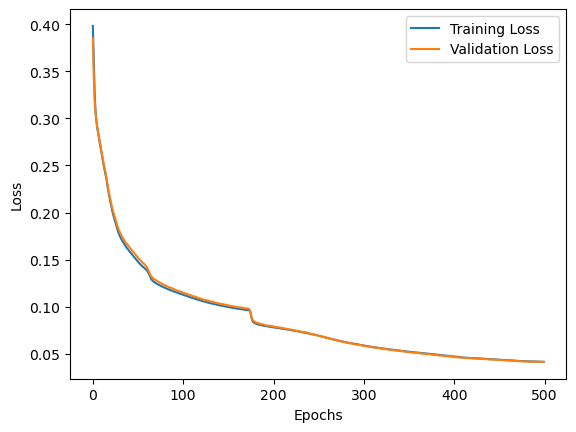

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
y_pred_test = model.predict([X_real_test, X_imag_test])
y_pred_test_rescaled = y_pred_test * (q - 1)
# y_pred_test_rescaled = (y_pred_test * y_std) + y_mean
y_test_rescaled = y_test * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_test_rescaled[i])}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i])}")
    print("-" * 40)

linear layer input: (None, 32)
linear layer output: (None, 16)
7/7 [==============================] - 1s 4ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [1. 0. 2. 1. 1. 1. 3. 0. 1. 3. 2. 2. 1. 0. 4. 2.]
  Ground Truth: [1. 0. 1. 1. 1. 1. 3. 0. 1. 3. 1. 2. 1. 1. 4. 2.]
----------------------------------------
Sample 2:
  Predicted:    [4. 0. 2. 1. 2. 0. 3. 1. 1. 2. 2. 1. 3. 0. 1. 0.]
  Ground Truth: [4. 0. 2. 0. 2. 0. 3. 2. 1. 2. 2. 2. 3. 0. 1. 0.]
----------------------------------------
Sample 3:
  Predicted:    [3. 2. 1. 1. 2. 0. 4. 4. 3. 3. 2. 1. 4. 3. 1. 1.]
  Ground Truth: [3. 2. 0. 0. 2. 0. 4. 4. 3. 3. 1. 3. 4. 3. 0. 1.]
----------------------------------------


predict on unseen data

In [27]:
num_unseen_samples = 5
unseen_data = np.random.randint(0, q, size=(num_unseen_samples, n))

unseen_data_normalized = unseen_data.astype(np.float32) / (q - 1)

# print("Unseen Input Data (Before Encoding):")
# print(unseen_data)

unseen_encoded = np.array([dft(message, n) for message in unseen_data])
unseen_encoded[np.abs(unseen_encoded) < 1e-10] = 0
unseen_encoded = np.round(unseen_encoded, decimals=10)

X_real_unseen = np.real(unseen_encoded).astype(np.float32)
X_imag_unseen = np.imag(unseen_encoded).astype(np.float32)

print("\nEncoded Unseen Data (Real and Imaginary Parts):")
print("Real Part Shape:", X_real_unseen.shape)
print("Imaginary Part Shape:", X_imag_unseen.shape)

y_pred_unseen = model.predict([X_real_unseen, X_imag_unseen])

y_pred_unseen_rescaled = y_pred_unseen * (q - 1)

y_pred_unseen_final = np.mod(np.round(y_pred_unseen_rescaled), q)

print("\nComparison of Unseen Data and Predictions:")
print("=" * 60)
for i in range(num_unseen_samples):
    print(f"Sample {i+1}:")
    print(f"  Ground Truth: {unseen_data[i]}")
    print(f"  Prediction  : {y_pred_unseen_final[i].astype(int)}")
    print("-" * 60)


Encoded Unseen Data (Real and Imaginary Parts):
Real Part Shape: (5, 16)
Imaginary Part Shape: (5, 16)
1/1 [==============================] - 0s 71ms/step

Comparison of Unseen Data and Predictions:
Sample 1:
  Ground Truth: [2 3 2 1 0 0 0 4 4 1 2 4 2 2 4 4]
  Prediction  : [2 3 3 2 0 0 0 4 4 1 2 2 2 2 4 4]
------------------------------------------------------------
Sample 2:
  Ground Truth: [1 3 0 4 4 2 3 4 3 0 2 1 0 3 3 0]
  Prediction  : [1 3 1 4 4 1 3 4 3 1 2 1 1 3 3 0]
------------------------------------------------------------
Sample 3:
  Ground Truth: [3 1 1 3 3 1 3 4 2 4 3 3 2 3 2 1]
  Prediction  : [3 1 1 3 3 2 3 4 2 4 3 2 2 2 2 1]
------------------------------------------------------------
Sample 4:
  Ground Truth: [2 2 4 3 1 0 2 0 3 2 0 4 0 4 1 3]
  Prediction  : [2 2 3 3 1 0 2 0 3 2 1 2 0 4 1 2]
------------------------------------------------------------
Sample 5:
  Ground Truth: [0 2 3 0 2 2 2 2 0 1 4 4 4 1 2 2]
  Prediction  : [0 2 2 1 2 2 2 1 0 1 3 3 4 1 2 2]
------

Check gradient flow

In [28]:
for layer in model.layers:
    if layer.trainable_variables:
        grads = tf.reduce_mean(tf.abs(layer.trainable_variables[0]))
        print(layer.name, "Gradient Mean:", grads.numpy())
    else:
        print(layer.name, "has no trainable variables.")

real_input has no trainable variables.
imag_input has no trainable variables.
real_layer1 Gradient Mean: 0.5921713
imag_layer1 Gradient Mean: 0.45857573
leaky_re_lu has no trainable variables.
leaky_re_lu_3 has no trainable variables.
real_support_layer_1 Gradient Mean: 1.7383046
imag_support_layer_1 Gradient Mean: 2.430495
leaky_re_lu_1 has no trainable variables.
leaky_re_lu_4 has no trainable variables.
real_layer2 Gradient Mean: 1.3402917
imag_layer2 Gradient Mean: 1.4488969
leaky_re_lu_2 has no trainable variables.
leaky_re_lu_5 has no trainable variables.
merge_real_imag has no trainable variables.
output_layer Gradient Mean: 2.0532532
activation has no trainable variables.


In [29]:
batch_size = 4 
X_real_dummy = np.random.rand(batch_size, X_real_train.shape[1]).astype(np.float32)
X_imag_dummy = np.random.rand(batch_size, X_imag_train.shape[1]).astype(np.float32)
y_dummy = np.random.rand(batch_size, y_train.shape[1]).astype(np.float32)

def check_gradients(model, X_real_dummy, X_imag_dummy, y_dummy):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        predictions = model([X_real_dummy, X_imag_dummy], training=True)
        loss = tf.keras.losses.mean_squared_error(y_dummy, predictions)

    grads = tape.gradient(loss, model.trainable_variables)

    for i, (grad, var) in enumerate(zip(grads, model.trainable_variables)):
        if grad is None:
            print(f"🚨 Gradient is None for {var.name} at index {i}")
        else:
            print(f"✅ Gradient OK for {var.name}, mean: {tf.reduce_mean(grad).numpy()}")

check_gradients(model, X_real_dummy, X_imag_dummy, y_dummy)


linear layer input: (4, 32)
linear layer output: (4, 16)
✅ Gradient OK for real_layer1/kernel_b1:0, mean: -0.0009824737207964063
✅ Gradient OK for real_layer1/kernel_b2:0, mean: -0.0006573835271410644
✅ Gradient OK for real_layer1/kernel_d1:0, mean: -0.0021592092234641314
✅ Gradient OK for real_layer1/kernel_d2:0, mean: -0.0006244988762773573
✅ Gradient OK for real_layer1/bias:0, mean: -0.0009485393529757857
✅ Gradient OK for imag_layer1/kernel_b1:0, mean: -0.0068637914955616
✅ Gradient OK for imag_layer1/kernel_b2:0, mean: -0.0009827979374676943
✅ Gradient OK for imag_layer1/kernel_d1:0, mean: -0.006361318286508322
✅ Gradient OK for imag_layer1/kernel_d2:0, mean: 0.00047864290536381304
✅ Gradient OK for imag_layer1/bias:0, mean: -0.01564641483128071
✅ Gradient OK for real_support_layer_1/kernel_m:0, mean: -0.009587676264345646
✅ Gradient OK for real_support_layer_1/bias:0, mean: -0.0012309917947277427
✅ Gradient OK for imag_support_layer_1/kernel_m:0, mean: -0.02593168243765831
✅ Grad